In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -qq "/content/drive/MyDrive/yt-classifier/thumbnail.zip"

In [ ]:
import tensorflow as tf

# GPU 디바이스 목록 가져오기
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    # GPU가 존재하는 경우
    for gpu in gpus:
        print("GPU가 감지되었습니다:", gpu)
else:
    print("GPU를 찾을 수 없습니다. CPU를 사용합니다.")

GPU가 감지되었습니다: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [ ]:
!pip install ResNet

# ResNet

In [ ]:
import os
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

# 데이터셋 경로 설정
base_dir = './thumbnail'

# 클래스 이름 설정 (폴더 번호에 맞게 설정)
class_names = sorted(os.listdir(base_dir))

# 이미지 사이즈 설정
img_height = 320
img_width = 180

# 데이터셋 생성
data = []
labels = []

for i, class_name in enumerate(class_names):
    class_dir = os.path.join(base_dir, class_name)
    img_paths = [os.path.join(class_dir, img_name) for img_name in os.listdir(class_dir)]
    labels.extend([i] * len(img_paths))
    data.extend(img_paths)

# 데이터셋 분할
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.3, random_state=42)

# 데이터 제너레이터 정의
def data_generator(images, labels, batch_size):
    num_samples = len(images)
    while True:
        indices = np.random.randint(0, num_samples, batch_size)
        batch_images = []
        batch_labels = []
        for index in indices:
            img_path = images[index]
            img = load_img(img_path, target_size=(img_height, img_width))
            img_array = img_to_array(img)
            batch_images.append(img_array)
            batch_labels.append(labels[index])
        batch_images = np.array(batch_images)
        batch_labels = to_categorical(batch_labels, num_classes=len(class_names))
        yield batch_images, batch_labels

# ResNet 모델 로드
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# 새로운 레이어 추가
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(32, activation='relu')(x)
predictions = Dense(len(class_names), activation='softmax')(x)

# 전체 모델 정의
model_resnet = Model(inputs=base_model.input, outputs=predictions)

# 기존 레이어 동결
for layer in base_model.layers:
    layer.trainable = False

# 모델 컴파일
model_resnet.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 모델 학습
batch_size = 32
train_generator = data_generator(train_data, train_labels, batch_size)
test_generator = data_generator(test_data, test_labels, batch_size)

steps_per_epoch = len(train_data) // batch_size
validation_steps = len(test_data) // batch_size

history = model_resnet.fit(train_generator, epochs=100, steps_per_epoch=steps_per_epoch,
                           validation_data=test_generator, validation_steps=validation_steps)

# 모델 평가
test_loss, test_accuracy = model_resnet.evaluate(test_generator, steps=validation_steps)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


94765736/94765736 [==============================] - 5s 0us/step
Epoch 1/100
311/311 [==============================] - 42s 94ms/step - loss: 2.1222 - accuracy: 0.3169 - val_loss: 2.0430 - val_accuracy: 0.3219
Epoch 2/100
311/311 [==============================] - 28s 91ms/step - loss: 1.8700 - accuracy: 0.3931 - val_loss: 2.0365 - val_accuracy: 0.3445
Epoch 3/100
311/311 [==============================] - 28s 90ms/step - loss: 1.7255 - accuracy: 0.4441 - val_loss: 1.9403 - val_accuracy: 0.3743
Epoch 4/100
311/311 [==============================] - 28s 90ms/step - loss: 1.6336 - accuracy: 0.4726 - val_loss: 1.8633 - val_accuracy: 0.4093
Epoch 5/100
311/311 [==============================] - 27s 89ms/step - loss: 1.5411 - accuracy: 0.5043 - val_loss: 1.8904 - val_accuracy: 0.4013
Epoch 6/100
311/311 [==============================] - 28s 92ms/step - loss: 1.5195 - accuracy: 0.5024 - val_loss: 1.8368 - val_accuracy: 0.4159
Epoch 7/100
311/311 [==============================] - 28s 91ms/s

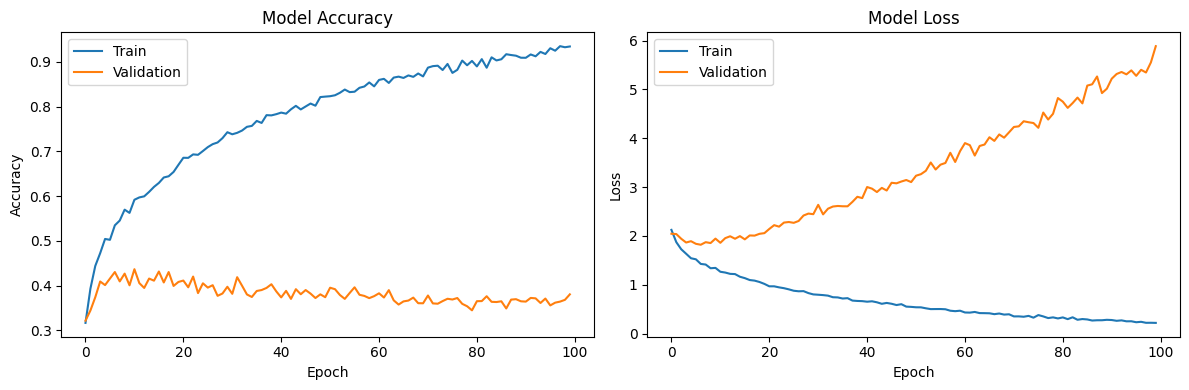

1/1 [==============================] - 1s 1s/step


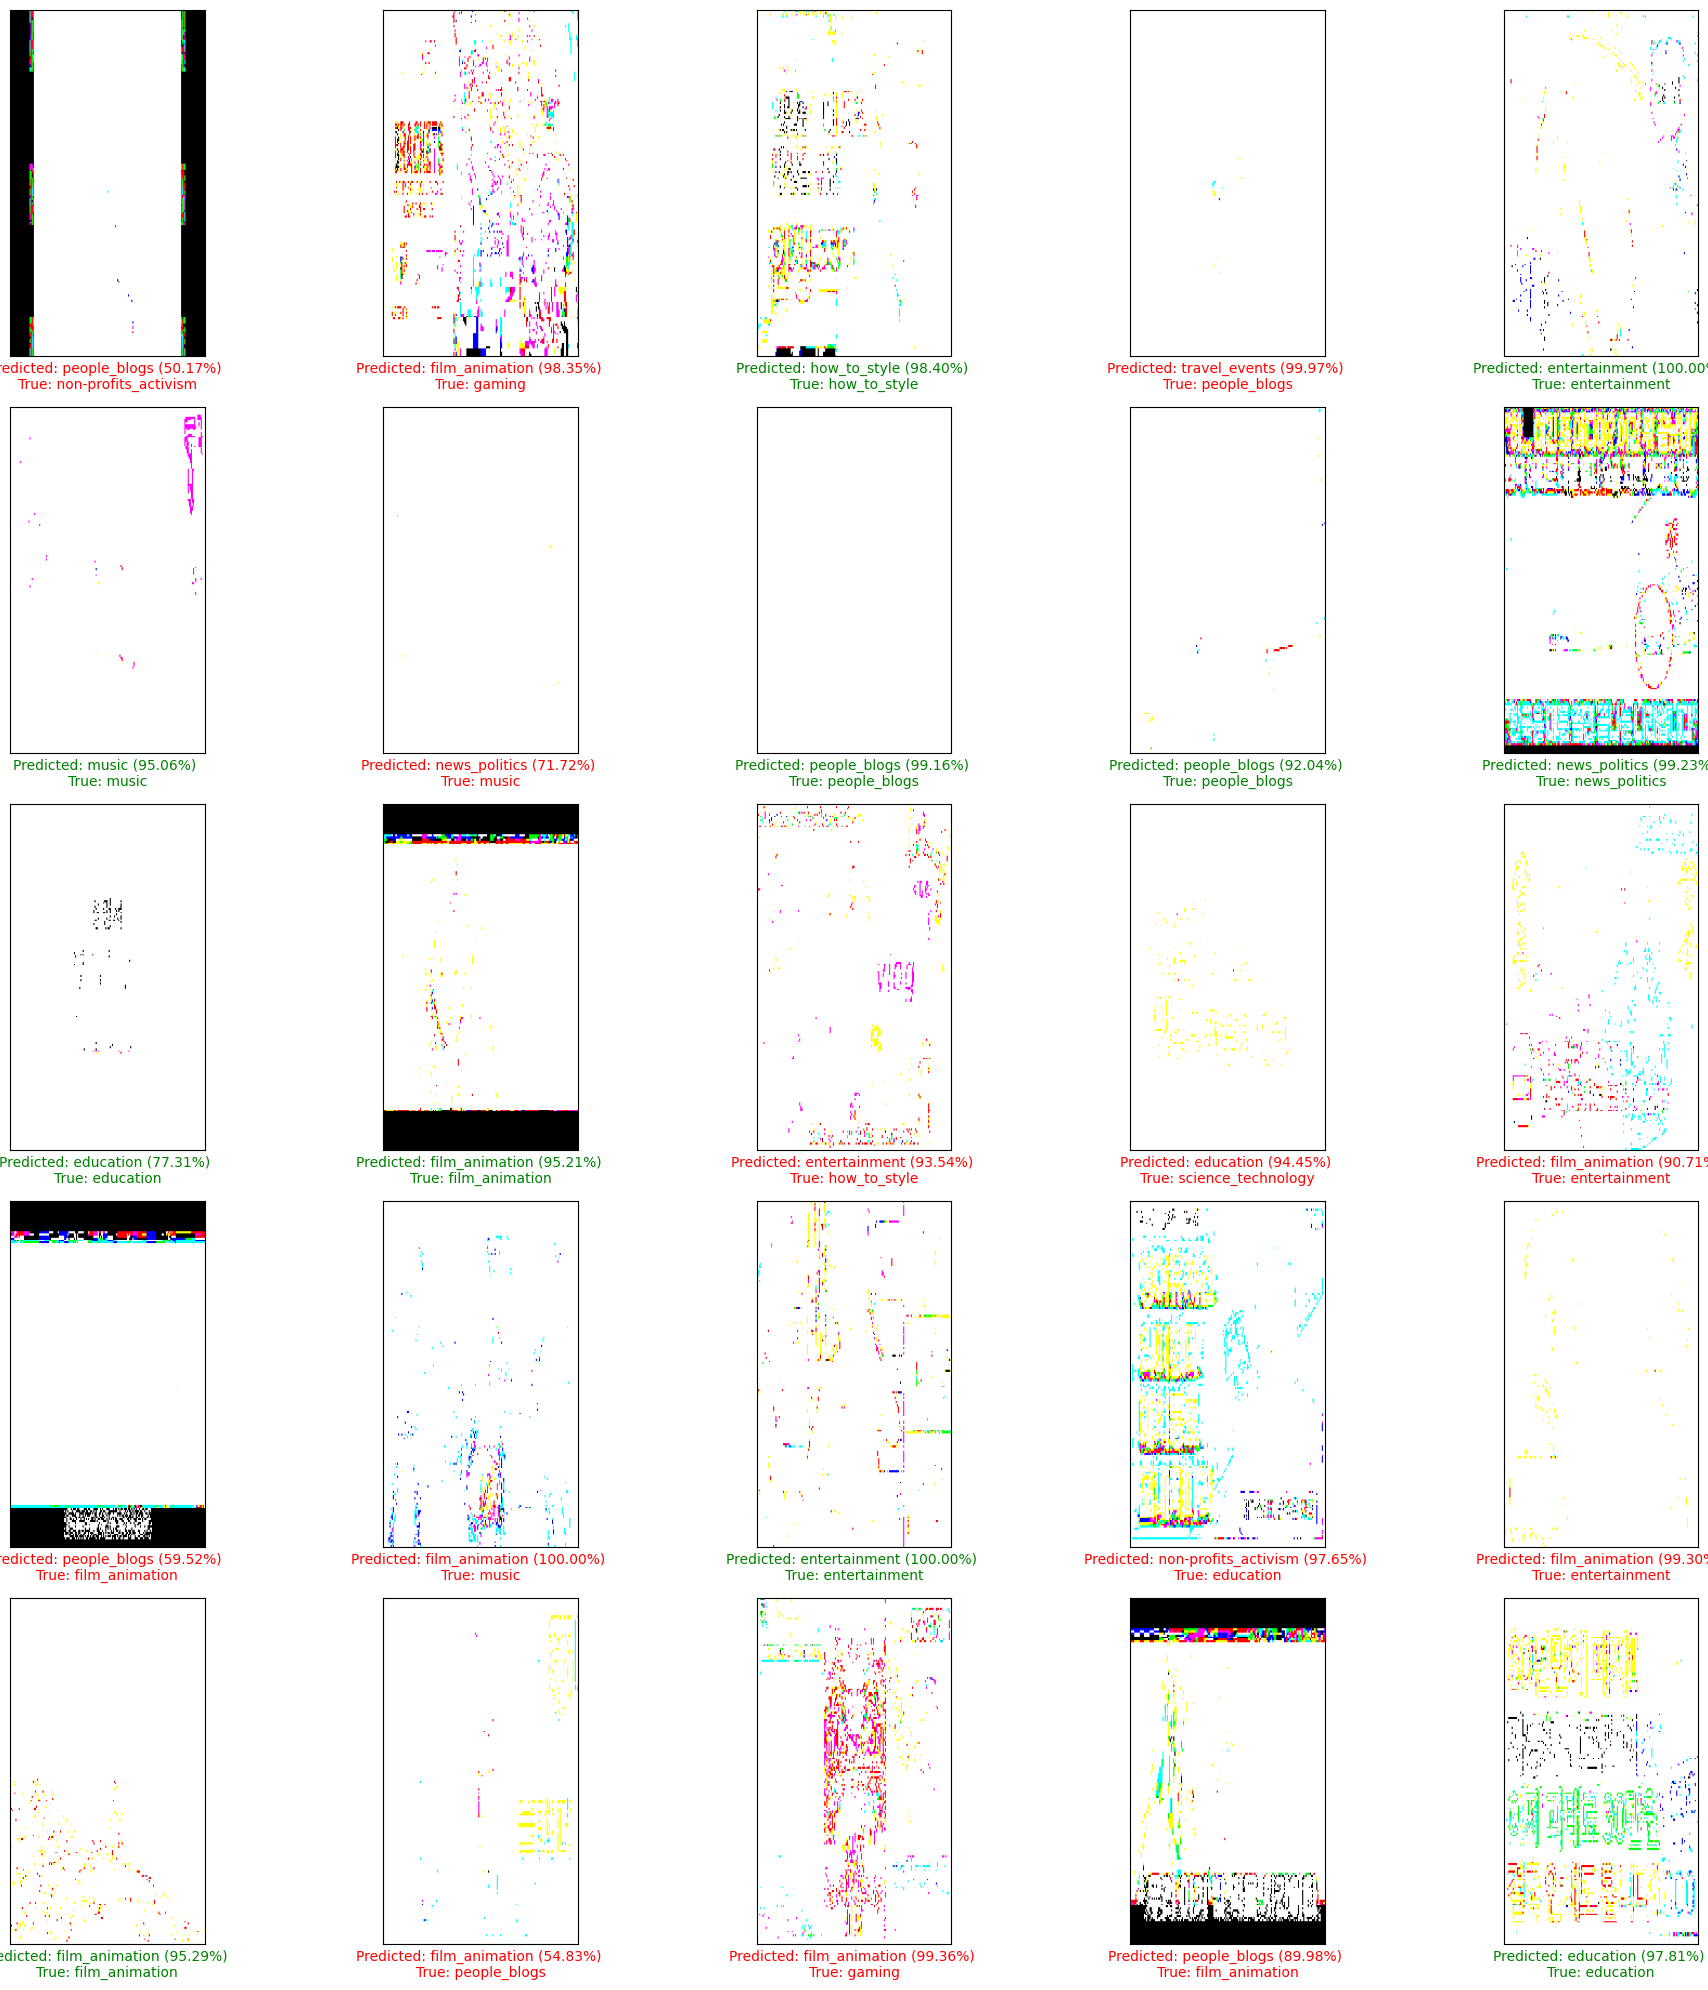

In [ ]:
import matplotlib.pyplot as plt

# 학습 과정 시각화
def plot_training_history(history):
    # 정확도 그래프
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)    
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # 손실 함수 그래프
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

# 학습 과정 시각화
plot_training_history(history)

# 테스트 결과 시각화
def plot_test_results(model, test_generator, num_images=25):
    test_images, test_labels = next(test_generator)
    predictions = model.predict(test_images)
    class_names = sorted(os.listdir(base_dir))

    plt.figure(figsize=(20, 20))
    for i in range(min(num_images, len(test_images))):
        plt.subplot(5, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(test_images[i], cmap=plt.cm.binary)
        predicted_label = np.argmax(predictions[i])
        true_label = np.argmax(test_labels[i])
        if predicted_label == true_label:
            color = 'green'
        else:
            color = 'red'
        plt.xlabel("Predicted: {} ({:.2f}%) \nTrue: {}".format(
            class_names[predicted_label], predictions[i][predicted_label] * 100, class_names[true_label]), color=color)
    plt.tight_layout()
    plt.show()

# 테스트 결과 시각화
plot_test_results(model_resnet, test_generator, num_images=25)


1/1 [==============================] - 1s 1s/step


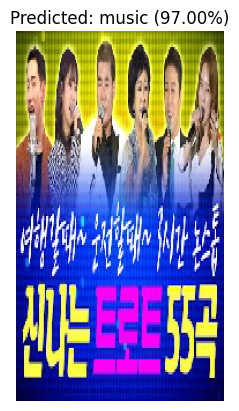

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 예측 결과 시각화 및 분석
def predict_image(model, image_path, class_names):
    img_path = image_path
    img = load_img(img_path, target_size=(img_height, img_width))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    predicted_label = np.argmax(prediction)
    confidence = prediction[0][predicted_label] * 100

    plt.imshow(img)
    plt.axis('off')
    plt.title("Predicted: {} ({:.2f}%)".format(class_names[predicted_label], confidence))
    plt.show()

# 이미지 예측
image_path = '/content/thumbnail/music/DzPNXqvVqZM.jpg'
predict_image(model_resnet, image_path, class_names)

In [ ]:
model_resnet.save('resnet_train.keras')
!cp resnet_train.keras drive/MyDrive/resnet_train.keras